# Finite Impulse Response Filter Implementation

### Author: Cagil Gumus


$$ y_n = \sum_{k=0}^{M-1} h_k x_{n-k} $$


where $ x_{n} $ is the ADC output (eg. 16 bits signed) and $ h_k $ is the coefficients. The word taps is used for $ M $. For example: 2-taps FIR filter would have the form: 

$$ y_n = x_{n}/2 + x_{n-1}/2 $$

[Referenced from here](https://www.cbcity.de/die-fft-mit-python-einfach-erklaert)



In [1]:
from __future__ import division
from scipy import signal, fft, ifft
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import numpy as np
import matplotlib.pyplot as plt


### $y_{n} $ Signal Construction

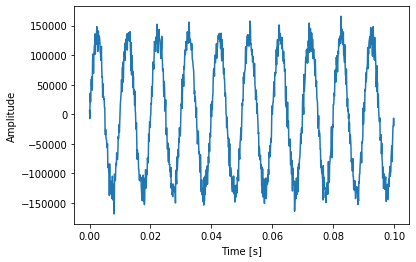

In [2]:
freq = 100 # in Hz 
sampling_freq = 10000 # in Hz
periods = 10 # Number of periods to be printed
amplitude = 2**17-2

np.random.seed(1234) # needed for adding jitter

x = np.arange(0,periods/freq, 1/sampling_freq)  # x-axis construction

total_samples = len(x)

y = amplitude * (np.sin(2*np.pi*freq*x) + 0.1*np.random.randn(x.size))  # y-axis construction
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(x,y)
plt.show()

Let's take a look at the Fast Fourier Transform of our signal: $\mathcal{F}(y_{n}) $

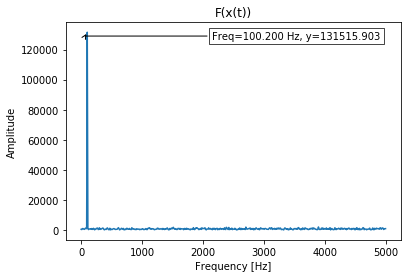

In [3]:
fft_signal = fft(y)

freq_range = total_samples/2  # We are interested in 1-half of the frequency spectrum

xfreq = np.linspace(0,sampling_freq/2, freq_range)
fft_signal_abs = (2/total_samples)*abs(fft_signal[:int(freq_range)])
plt.title("F(x(t))")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(xfreq,fft_signal_abs) # 2/N normalization

# Fucntion for finding the peak frequency
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Freq={:.3f} Hz, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
annot_max(xfreq,fft_signal_abs)

plt.show()

### Side information

We can eliminate the 'Leakage effect' by introducing the windows that amplitude modulate the $x_{n}$

However we will not use this now.

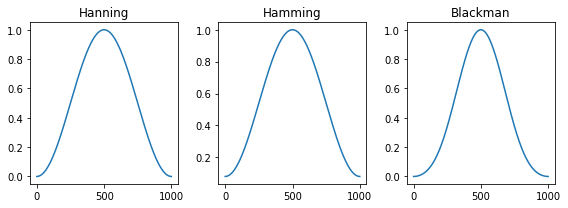

In [4]:
hann = np.hanning(len(y))
hamm = np.hamming(len(y))
black= np.blackman(len(y))

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(hann)
plt.title('Hanning')
plt.subplot(132)
plt.plot(hamm)
plt.title('Hamming')
plt.subplot(133)
plt.plot(black)
plt.title('Blackman')
plt.tight_layout()

Now lets amplitude modulate our input signal with Hanning Window

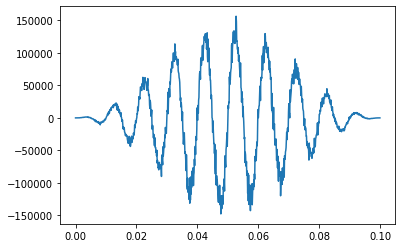

In [5]:
windowed_y = y*hann
plt.plot(x,windowed_y)
plt.show()

## Designing the FIR filter

Now we design our N-tap FIR filter.

We can $kaiserord$ from scipy package to come up with the order and the taps of the FIR Filter


Ps: This example is taken from [SciPy Cookbook](https://scipy-cookbook.readthedocs.io/items/FIRFilter.html)

In [6]:
fir_order = 300                   # Filter Order
cutoff_hz = 100                # The cutoff frequency of the filter.

Now we can start constructing the FIR filter with given parameters

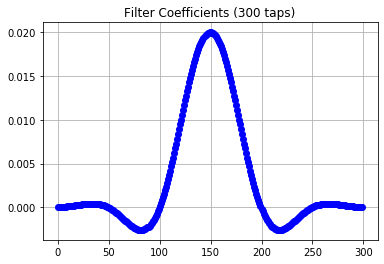

/home/guemues/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

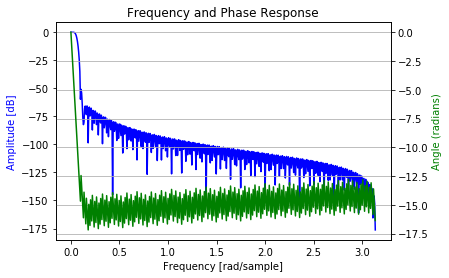

In [7]:
# Use firwin with a Kaiser window to create a lowpass FIR filter.
nyq_rate = sampling_freq / 2.0  # The Nyquist rate of the signal.

taps = firwin(fir_order, cutoff_hz/nyq_rate)

figure(1)
plot(taps, 'bo-', linewidth=1)
title('Filter Coefficients (%d taps)' % len(taps))
grid(True)
plt.show()
#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------
w, h = freqz(taps) # w = Frequencies in unit of fs.  w is normalized to the range [0, pi) (radians/sample).
                   # h = The frequency response, as complex numbers
figure(2)
clf() # Clear the current figure

fig = plt.figure()
plt.title('Frequency and Phase Response')

ax1 = fig.add_subplot(111)
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()


### Convolve $y_{n}$ with $taps$

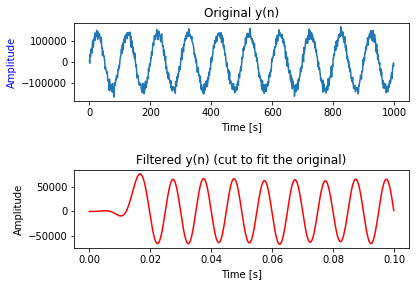

In [8]:
# Use lfilter to filter x with the FIR filter.
# filtered_y = lfilter(taps, 1, y)     # This returns len(y) number of samples
filtered_y = np.convolve(y,taps)    # This returns len(y) + filter_order-1 number of samples

plt.subplot(2, 1, 1)
plt.title('Original y(n)')
plt.ylabel('Amplitude', color='b')
plt.xlabel('Time [s]')
plot(y)

plt.subplot(2, 1, 2)

plt.subplots_adjust(hspace = 0.9, bottom=0.1 )
plt.title('Filtered y(n) (cut to fit the original)')
plot(x,filtered_y[:len(x)], 'r')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')

plt.show()

## Exporting generated signal

Our idea is to export the generated noisy sine wave to txt file.
However we need to represent our signal in signed 18 bit integer form. 

We are multiplying taps with $2^{17}$ to shift the comma to 0'th position.

We also need to export our taps in the same format as $y_{n}$

In [9]:
taps_scaled = taps*2**17

y_binary = []
filtered_y_binary = []
taps_binary = []

for i in range(len(y)):
    y_binary.append(format(y.astype(int)[i] & 0b111111111111111111, '018b'))
    filtered_y_binary.append(format(filtered_y.astype(int)[i] & 0b111111111111111111, '018b'))
    
for i in range(len(taps)):
    taps_binary.append(format(taps_scaled.astype(int)[i] & 0b111111111111111111, '018b'))

f = open('file.txt', 'w')

# Writing coeffiecients first
for i in range(len(taps_binary)):
    f.write(taps_binary[i] + '\n')

# Writing constructed y signal second
for i in range(len(y)):
    f.write(y_binary[i] + ' ' + filtered_y_binary[i] + "\n")          

f.close()